In [7]:
import sys
sys.dont_write_bytecode = True

import pandas as pd
import graphviz
import gurobipy as gp
from gurobipy import GRB
sys.path.append("simulator")
from simulator import simulator as sim

In [2]:
sim.three_depth_application()

User capacity: 99999999
A capacity: 33.333333333333336
B capacity: 100.0
C capacity: 40.0
D capacity: 25.0
E capacity: 33.333333333333336
F capacity: 100.0
- num_replica_for_cluster_0
	- User: 1
	- A: 2
	- B: 2
	- C: 2
	- D: 2
	- E: 2
	- F: 2
- num_replica_for_cluster_1
	- User: 1
	- A: 2
	- B: 2
	- C: 2
	- D: 2
	- E: 2
	- F: 2
===== print_service_and_replica =====
User
	cluster 0 User_0(node[0000])
	cluster 1 User_1(node[1000])
A
	cluster 0 A_0(node[0000])
	cluster 0 A_2(node[0000])
	cluster 1 A_1(node[1000])
	cluster 1 A_3(node[1000])
B
	cluster 0 B_0(node[0000])
	cluster 0 B_2(node[0000])
	cluster 1 B_1(node[1000])
	cluster 1 B_3(node[1000])
C
	cluster 0 C_0(node[0000])
	cluster 0 C_2(node[0000])
	cluster 1 C_1(node[1000])
	cluster 1 C_3(node[1000])
D
	cluster 0 D_0(node[0000])
	cluster 0 D_2(node[0000])
	cluster 1 D_1(node[1000])
	cluster 1 D_3(node[1000])
E
	cluster 0 E_0(node[0000])
	cluster 0 E_2(node[0000])
	cluster 1 E_1(node[1000])
	cluster 1 E_3(node[1000])
F
	cluster 0 F_0(

(<simulator.simulator.Replica at 0x7f9008c97640>,
 <simulator.simulator.Service at 0x7f8fd8203a90>)

In [65]:
def trunc(temp):
    st = temp.find("(")
    en = temp.find(")")
    temp = temp[:st]
    # print(temp)
    return temp

network_latency = sim.NetworkLatency()

# num_request = [1, 1]
num_request = [100, 100]

source = dict()
for repl in sim.dag.all_replica:
    if repl.service.name == "User":
        source[trunc(repl.to_str())] = num_request[repl.cluster_id]
print("source (load):", source)

total_num_request = sum(x for x in num_request)
destination = dict({"dst": total_num_request})
print("destination:", destination)

node = dict()
max_tput = total_num_request
for repl in sim.dag.all_replica:
    if repl.service.name != "User":
        node[trunc(repl.to_str())+"_start"] = max_tput
        node[trunc(repl.to_str())+"_end"] = max_tput
print("node: ", node)
    
multi_dict_ = dict()
# Processing time
for repl in sim.dag.all_replica:
    if repl.service.name != "User":
        multi_dict_[(trunc(repl.to_str())+"_start", trunc(repl.to_str())+"_end")] = repl.service.processing_time
# Network latency
for parent_repl in sim.dag.child_replica:
    for child_svc in sim.dag.child_replica[parent_repl]:
        child_repl_list = sim.dag.child_replica[parent_repl][child_svc]
        for child_repl in child_repl_list:
            if parent_repl.service.name == "User":
                multi_dict_[(trunc(parent_repl.to_str()), trunc(child_repl.to_str())+"_start")] = sim.NetworkLatency().get_latency(parent_repl, child_repl)*2
            else:
                multi_dict_[(trunc(parent_repl.to_str())+"_end", trunc(child_repl.to_str())+"_start")] = sim.NetworkLatency().get_latency(parent_repl, child_repl)*2
for repl in sim.dag.all_replica:
    if sim.dag.is_leaf(repl.service):
        multi_dict_[(trunc(repl.to_str())+"_end", "dst")] = 0.0
        
arcs, latency = gp.multidict(multi_dict_)
latency

source (load): {'User_0': 100, 'User_1': 100}
destination: {'dst': 200}
node:  {'A_0_start': 200, 'A_0_end': 200, 'A_2_start': 200, 'A_2_end': 200, 'B_0_start': 200, 'B_0_end': 200, 'B_2_start': 200, 'B_2_end': 200, 'C_0_start': 200, 'C_0_end': 200, 'C_2_start': 200, 'C_2_end': 200, 'D_0_start': 200, 'D_0_end': 200, 'D_2_start': 200, 'D_2_end': 200, 'E_0_start': 200, 'E_0_end': 200, 'E_2_start': 200, 'E_2_end': 200, 'F_0_start': 200, 'F_0_end': 200, 'F_2_start': 200, 'F_2_end': 200, 'A_1_start': 200, 'A_1_end': 200, 'A_3_start': 200, 'A_3_end': 200, 'B_1_start': 200, 'B_1_end': 200, 'B_3_start': 200, 'B_3_end': 200, 'C_1_start': 200, 'C_1_end': 200, 'C_3_start': 200, 'C_3_end': 200, 'D_1_start': 200, 'D_1_end': 200, 'D_3_start': 200, 'D_3_end': 200, 'E_1_start': 200, 'E_1_end': 200, 'E_3_start': 200, 'E_3_end': 200, 'F_1_start': 200, 'F_1_end': 200, 'F_3_start': 200, 'F_3_end': 200}


{('A_0_start', 'A_0_end'): 30,
 ('A_2_start', 'A_2_end'): 30,
 ('B_0_start', 'B_0_end'): 10,
 ('B_2_start', 'B_2_end'): 10,
 ('C_0_start', 'C_0_end'): 25,
 ('C_2_start', 'C_2_end'): 25,
 ('D_0_start', 'D_0_end'): 40,
 ('D_2_start', 'D_2_end'): 40,
 ('E_0_start', 'E_0_end'): 30,
 ('E_2_start', 'E_2_end'): 30,
 ('F_0_start', 'F_0_end'): 10,
 ('F_2_start', 'F_2_end'): 10,
 ('A_1_start', 'A_1_end'): 30,
 ('A_3_start', 'A_3_end'): 30,
 ('B_1_start', 'B_1_end'): 10,
 ('B_3_start', 'B_3_end'): 10,
 ('C_1_start', 'C_1_end'): 25,
 ('C_3_start', 'C_3_end'): 25,
 ('D_1_start', 'D_1_end'): 40,
 ('D_3_start', 'D_3_end'): 40,
 ('E_1_start', 'E_1_end'): 30,
 ('E_3_start', 'E_3_end'): 30,
 ('F_1_start', 'F_1_end'): 10,
 ('F_3_start', 'F_3_end'): 10,
 ('User_0', 'A_0_start'): 1.0,
 ('User_0', 'A_2_start'): 1.0,
 ('User_0', 'A_1_start'): 60.0,
 ('User_0', 'A_3_start'): 60.0,
 ('A_0_end', 'B_0_start'): 1.0,
 ('A_0_end', 'B_2_start'): 1.0,
 ('A_0_end', 'B_1_start'): 60.0,
 ('A_0_end', 'B_3_start'): 60.0,


In [66]:
##############################################################################
model = gp.Model('RequestRouting')
flow = model.addVars(arcs, obj=latency, name="flow")
print("type(flow):", type(flow))
print("flow:", flow)
test_node = "B_1_start"
print("flow.sum(\'*\', test_node):", flow.sum('*', test_node))
print("flow.select(\'*\', test_node:", flow.select('*', test_node))
print("arcs.select(\'*\', test_node):", arcs.select('*', test_node))

# Constraint 1: source
src_keys = source.keys()
src_flow = model.addConstrs((gp.quicksum(flow.select(src, '*')) == source[src] for src in src_keys), name="source")

# Constraint 2: destination
dest_keys = destination.keys()
num_leaf_svc = 0
leaf_svc = list()
for svc in sim.dag.all_service:
    print("iterate ", svc.name)
    if sim.dag.is_leaf(svc):
        num_leaf_svc += 1
        leaf_svc.append(svc.name)
print("leaf_svc: ", leaf_svc)
print("num_leaf_svc: ", num_leaf_svc)
dst_flow = model.addConstrs((gp.quicksum(flow.select('*', dst)) == destination[dst]*num_leaf_svc for dst in dest_keys), name="destination")

# Constraint 3: flow conservation
# node_key = node.keys()
# node_flow = model.addConstrs((gp.quicksum(flow.select('*', n_)) == gp.quicksum(flow.select(n_, '*')) for n_ in node_key), name="flow_conservation")
for repl in sim.dag.all_replica:
    if repl.service.name != "User":
        # Start node in-out flow conservation
        st = trunc(repl.to_str())+"_start"
        node_flow = model.addConstr((gp.quicksum(flow.select('*', st)) == gp.quicksum(flow.select(st, '*'))), name="flow_conservation["+st+"]")
        # End node in-out flow conservation
        en = trunc(repl.to_str())+"_end"
        if sim.dag.is_leaf(repl.service):
            node_flow = model.addConstr((gp.quicksum(flow.select('*', en)) == gp.quicksum(flow.select(en, '*'))), name="flow_conservation["+en+"]")
        else:
            for child_svc in repl.child_services:
                out_sum = 0
                for child_repl in child_svc.replicas:
                    child_repl_name = trunc(child_repl.to_str()) + "_start"
                    out_sum += flow.sum(en, child_repl_name)
                node_flow = model.addConstr((gp.quicksum(flow.select('*', en)) == out_sum), name="flow_conservation["+en+"]")

# Constraint 4: Tree topology
for svc in sim.dag.all_service:
    if svc.name != "User":
        svc_repl = svc.replicas
        sum_ = 0
        for repl in svc_repl:
            repl_name = trunc(repl.to_str()) + "_start"
            sum_ += flow.sum('*', repl_name)
        #     print("repl_name:", repl_name)
        #     print("flow.sum('*', repl_name):", flow.sum('*', repl_name))
        # print("flow sum ({}): {}".format(svc.name, sum_))
        node_flow = model.addConstr(sum_ == total_num_request, name="tree_topo_conservation")
        # print()

# Constraint 5: max throughput of service
node_key = node.keys()
throughput = model.addConstrs((gp.quicksum(flow.select('*', n_)) <= node[n_] for n_ in node_key), name="service_capacity")

##############################################################################
model.optimize()

# Variable info
varInfo = [(v.varName, v.LB, v.UB) for v in model.getVars() ] # use list comprehension
df_var = pd.DataFrame(varInfo) # convert to pandas dataframe
df_var.columns=['Variable Name','LB','UB'] # Add column headers
# with pd.option_context('display.max_rows', None,):
#     with pd.option_context('display.max_colwidth', None):
#         display(df_var)

# Linear constraint info
constrInfo = [(c.constrName, model.getRow(c), c.Sense, c.RHS) for c in model.getConstrs() ]
df_constr = pd.DataFrame(constrInfo)
df_constr.columns=['Constraint Name','Constraint equation', 'Sense','RHS']
with pd.option_context('display.max_rows', None,):
    with pd.option_context('display.max_colwidth', None):
        display(df_constr)
        
        
if model.Status == GRB.INFEASIBLE:
    print("###########################")
    print("#### INFEASIBLE MODEL! ####")
    print("###########################")
    model.computeIIS()
    model.write("model.ilp")
    print('\nThe following constraints and variables are in the IIS:')
    # for c in model.getConstrs():
    #     if c.IISConstr: print(f'\t{c.constrname}: {model.getRow(c)} {c.Sense} {c.RHS}')
    for v in model.getVars():
        if v.IISLB: print(f'\t{v.varname} ≥ {v.LB}')
        if v.IISUB: print(f'\t{v.varname} ≤ {v.UB}')
else:
    request_flow = pd.DataFrame(columns=["From", "To", "Flow"])
    for arc in arcs:
        if flow[arc].x > 1e-6:
            temp = pd.DataFrame({"From": [arc[0]], "To": [arc[1]], "Flow": [flow[arc].x]})
            request_flow = pd.concat([request_flow, temp], ignore_index=True)
    display(request_flow)

type(flow): <class 'gurobipy.tupledict'>
flow: {('A_0_start', 'A_0_end'): <gurobi.Var *Awaiting Model Update*>, ('A_2_start', 'A_2_end'): <gurobi.Var *Awaiting Model Update*>, ('B_0_start', 'B_0_end'): <gurobi.Var *Awaiting Model Update*>, ('B_2_start', 'B_2_end'): <gurobi.Var *Awaiting Model Update*>, ('C_0_start', 'C_0_end'): <gurobi.Var *Awaiting Model Update*>, ('C_2_start', 'C_2_end'): <gurobi.Var *Awaiting Model Update*>, ('D_0_start', 'D_0_end'): <gurobi.Var *Awaiting Model Update*>, ('D_2_start', 'D_2_end'): <gurobi.Var *Awaiting Model Update*>, ('E_0_start', 'E_0_end'): <gurobi.Var *Awaiting Model Update*>, ('E_2_start', 'E_2_end'): <gurobi.Var *Awaiting Model Update*>, ('F_0_start', 'F_0_end'): <gurobi.Var *Awaiting Model Update*>, ('F_2_start', 'F_2_end'): <gurobi.Var *Awaiting Model Update*>, ('A_1_start', 'A_1_end'): <gurobi.Var *Awaiting Model Update*>, ('A_3_start', 'A_3_end'): <gurobi.Var *Awaiting Model Update*>, ('B_1_start', 'B_1_end'): <gurobi.Var *Awaiting Model Up

,Constraint Name,Constraint equation,Sense,RHS
0,source[User_0],"flow[User_0,A_0_start] + flow[User_0,A_2_start] + flow[User_0,A_1_start] + flow[User_0,A_3_start]",=,100.0
1,source[User_1],"flow[User_1,A_0_start] + flow[User_1,A_2_start] + flow[User_1,A_1_start] + flow[User_1,A_3_start]",=,100.0
2,destination[dst],"flow[B_0_end,dst] + flow[B_2_end,dst] + flow[C_0_end,dst] + flow[C_2_end,dst] + flow[E_0_end,dst] + flow[E_2_end,dst] + flow[F_0_end,dst] + flow[F_2_end,dst] + flow[B_1_end,dst] + flow[B_3_end,dst] + flow[C_1_end,dst] + flow[C_3_end,dst] + flow[E_1_end,dst] + flow[E_3_end,dst] + flow[F_1_end,dst] + flow[F_3_end,dst]",=,800.0
3,flow_conservation[A_0_start],"-1.0 flow[A_0_start,A_0_end] + flow[User_0,A_0_start] + flow[User_1,A_0_start]",=,0.0
4,flow_conservation[A_0_end],"flow[A_0_start,A_0_end] + -1.0 flow[A_0_end,B_0_start] + -1.0 flow[A_0_end,B_2_start] + -1.0 flow[A_0_end,B_1_start] + -1.0 flow[A_0_end,B_3_start]",=,0.0
5,flow_conservation[A_0_end],"flow[A_0_start,A_0_end] + -1.0 flow[A_0_end,C_0_start] + -1.0 flow[A_0_end,C_2_start] + -1.0 flow[A_0_end,C_1_start] + -1.0 flow[A_0_end,C_3_start]",=,0.0
6,flow_conservation[A_0_end],"flow[A_0_start,A_0_end] + -1.0 flow[A_0_end,D_0_start] + -1.0 flow[A_0_end,D_2_start] + -1.0 flow[A_0_end,D_1_start] + -1.0 flow[A_0_end,D_3_start]",=,0.0
7,flow_conservation[A_2_start],"-1.0 flow[A_2_start,A_2_end] + flow[User_0,A_2_start] + flow[User_1,A_2_start]",=,0.0
8,flow_conservation[A_2_end],"flow[A_2_start,A_2_end] + -1.0 flow[A_2_end,B_0_start] + -1.0 flow[A_2_end,B_2_start] + -1.0 flow[A_2_end,B_1_start] + -1.0 flow[A_2_end,B_3_start]",=,0.0
9,flow_conservation[A_2_end],"flow[A_2_start,A_2_end] + -1.0 flow[A_2_end,C_0_start] + -1.0 flow[A_2_end,C_2_start] + -1.0 flow[A_2_end,C_1_start] + -1.0 flow[A_2_end,C_3_start]",=,0.0


,From,To,Flow
0,A_2_start,A_2_end,100.0
1,B_2_start,B_2_end,100.0
2,C_2_start,C_2_end,100.0
3,D_2_start,D_2_end,100.0
4,E_2_start,E_2_end,100.0
5,F_0_start,F_0_end,100.0
6,A_3_start,A_3_end,100.0
7,B_3_start,B_3_end,100.0
8,C_1_start,C_1_end,100.0
9,D_3_start,D_3_end,100.0


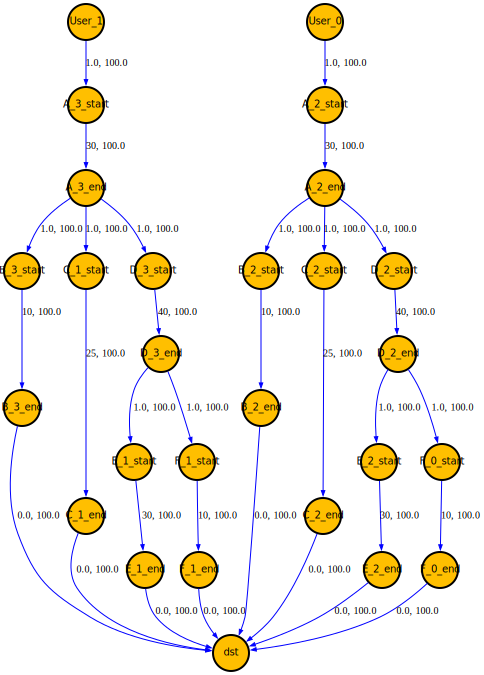

In [103]:
g_ = graphviz.Digraph()
# The node() method takes a name identifier as first argument and an optional label.
# The edge() method takes the names of start node and end node
# g_.size ="3,3"
print_all = True
node_pw = "2"
edge_pw = "1"
fs = "10"
edge_fs_0 = "10"
edge_fs_1 = "5"
fn="times bold italic"
edge_arrowsize="0.5"
edge_minlen="1"

if print_all:
    for k, v in latency.items():
        if k[0] in request_flow["From"].to_list() and k[1] in request_flow["To"].to_list():
            node_color = "#FFBF00"
            g_.node(name=k[0], label=k[0], shape='circle', style='filled', fillcolor=node_color, penwidth=node_pw, fontsize=fs, fontname=fn, fixedsize="True", width="0.5")
            g_.node(name=k[1], label=k[1], shape='circle', style='filled', fillcolor=node_color, penwidth=node_pw, fontsize=fs, fontname=fn, fixedsize="True", width="0.5")
        temp = request_flow[request_flow["From"]==k[0]]
        temp = temp[temp["To"]==k[1]]
        if len(temp) > 0:
            g_.edge(k[0], k[1], label=str(v)+", "+str(temp["Flow"].to_list()[0]), penwidth=edge_pw, style="filled", fontsize=edge_fs_0, color="blue", arrowsize=edge_arrowsize, minlen=edge_minlen)
else:
    for k, v in latency.items():
        if k[0] in request_flow["From"].to_list() and k[1] in request_flow["To"].to_list():
            node_color = "#FFBF00"
        else:
            node_color = "#A7A4A4"
        g_.node(name=k[0], label=k[0], shape='circle', style='filled', fillcolor=node_color, penwidth=node_pw, fontsize=fs, fontname=fn, fixedsize="True", width="0.75")
        g_.node(name=k[1], label=k[1], shape='circle', style='filled', fillcolor=node_color, penwidth=node_pw, fontsize=fs, fontname=fn, fixedsize="True")
        temp = request_flow[request_flow["From"]==k[0]]
        temp = temp[temp["To"]==k[1]]
        if len(temp) > 0:
            g_.edge(k[0], k[1], label=str(v)+", "+str(temp["Flow"].to_list()[0]), penwidth=edge_pw, style="filled", fontsize=edge_fs_0, color="blue", arrowsize=edge_arrowsize, minlen=edge_minlen)
        else:
            g_.edge(k[0], k[1], label=str(v), penwidth=edge_pw, style="dotted", fontsize=edge_fs_1, arrowhead="none", minlen=edge_minlen)
g_